# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">COSMIC CLASSIFIER</h1></span>

# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## ================================ ##

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report
)
from sklearn.impute import KNNImputer
%matplotlib inline

# Exploratory Data Analysis

#### Loading the data into Pandas dataframe

In [2]:
df=pd.read_csv("cosmicclassifierTraining.csv")
print(df.shape)
df.head()

(60000, 11)


,Atmospheric Density,Surface Temperature,Gravity,Water Content,Mineral Abundance,Orbital Period,Proximity to Star,Magnetic Field Strength,Radiation Levels,Atmospheric Composition Index,Prediction
0,0.472806,NaN,-0.313872,-2.089299,-0.152201,-0.885649,0.900105,NaN,Category_6,0.692907,5.0
1,4.180154,-1.157515,2.430956,-1.595850,-3.188678,-0.609434,-0.199828,Category_9,Category_9,NaN,0.0
2,-0.129008,1.621592,-0.785741,2.081196,-1.413796,-0.095152,-3.502577,NaN,Category_8,-0.677182,4.0
3,-3.122000,-2.299818,1.072092,0.353524,-0.192529,2.917067,-1.972329,NaN,Category_11,0.109429,1.0
4,-1.459426,2.890268,0.148757,-0.804439,0.494875,0.044910,-0.438796,Category_6,Category_10,0.407941,9.0


In [3]:
df.columns

Index(['Atmospheric Density', 'Surface Temperature', 'Gravity',
       'Water Content', 'Mineral Abundance', 'Orbital Period',
       'Proximity to Star', 'Magnetic Field Strength', 'Radiation Levels',
       'Atmospheric Composition Index', 'Prediction'],
      dtype='object')

In [4]:
df.describe()

,Atmospheric Density,Surface Temperature,Gravity,Water Content,Mineral Abundance,Orbital Period,Proximity to Star,Atmospheric Composition Index,Prediction
count,57016.000000,56968.000000,57016.000000,56923.000000,57079.000000,57003.000000,57055.000000,57058.000000,56961.000000
mean,-0.000202,-0.000288,-0.000469,0.001938,-0.000730,-0.001043,0.000188,0.000211,4.454381
std,2.263527,1.936598,1.804605,1.689267,1.605524,1.511685,1.316682,1.120303,2.890055
min,-4.364843,-5.503527,-5.553877,-5.816755,-5.077363,-4.801046,-4.537187,-4.007504,0.000000
25%,-1.555810,-1.426786,-1.279002,-1.218870,-1.078449,-1.048920,-0.937097,-0.709852,2.000000
50%,-0.188670,-0.330037,0.046231,-0.004676,0.040008,0.036651,-0.062001,0.049292,4.000000
75%,1.308113,1.503646,1.255432,1.063391,1.095483,1.058800,0.888149,0.789511,7.000000
max,9.324018,5.638094,6.030290,6.287045,5.584059,5.111014,4.942699,3.852567,9.000000


Mean for all columns (except Prediction) is almost zero indicating the data is scaled.

Categorical columns : Magnetic Field Strength, Radiation Levels

In [5]:
# from ydata_profiling import ProfileReport
# prof=ProfileReport(df)
# prof.to_file(output_file='testEDA.html')

### Dealing with Missing values in Numerical Columns

In [6]:
df.isnull().sum()

Atmospheric Density              2984
Surface Temperature              3032
Gravity                          2984
Water Content                    3077
Mineral Abundance                2921
Orbital Period                   2997
Proximity to Star                2945
Magnetic Field Strength          3058
Radiation Levels                 3021
Atmospheric Composition Index    2942
Prediction                       3039
dtype: int64

Dropping Columns where Prediction is Null

In [7]:
df=df.dropna(subset=['Prediction'])

Filling the missing values in rest of numerical columns with the median of the respective columns

In [8]:
df=df.fillna(df.select_dtypes(include=['number']).median())

In [9]:
df.isnull().sum()

Atmospheric Density                 0
Surface Temperature                 0
Gravity                             0
Water Content                       0
Mineral Abundance                   0
Orbital Period                      0
Proximity to Star                   0
Magnetic Field Strength          2941
Radiation Levels                 2859
Atmospheric Composition Index       0
Prediction                          0
dtype: int64

This indicates the data is fairly balanced

In [10]:
df['Prediction'].value_counts()

Prediction
1.0    6393
7.0    5929
3.0    5814
9.0    5650
2.0    5647
6.0    5638
0.0    5637
8.0    5568
4.0    5553
5.0    5132
Name: count, dtype: int64

### Categorical Columns Labeling and Cleaning

In [11]:
df['Magnetic Field Strength'].unique()

array([nan, 'Category_9', 'Category_6', 'Category_10', 'Category_8',
       'Category_14', 'Category_13', 'Category_7', 'Category_11',
       'Category_15', 'Category_12', 'Category_4', 'Category_5',
       'Category_16', 'Category_17', 'Category_3', 'Category_18',
       'Category_2', 'Category_19', 'Category_1', 'Category_20'],
      dtype=object)

In [12]:
df['Magnetic Field Strength'].value_counts()

Magnetic Field Strength
Category_9     8503
Category_8     8474
Category_10    7486
Category_7     5827
Category_11    5793
Category_12    4283
Category_6     3308
Category_13    3004
Category_14    2047
Category_5     1912
Category_15    1194
Category_4      841
Category_16     677
Category_3      307
Category_17     215
Category_18      63
Category_2       62
Category_19      15
Category_1        8
Category_20       1
Name: count, dtype: int64

In [13]:
df['Radiation Levels'].value_counts()

Radiation Levels
Category_8     9257
Category_9     9065
Category_7     7929
Category_10    7752
Category_11    5753
Category_6     4962
Category_12    3405
Category_5     2158
Category_13    1654
Category_4      818
Category_14     663
Category_15     245
Category_3      235
Category_16     103
Category_2       59
Category_17      27
Category_18      10
Category_1        5
Category_19       1
Category_20       1
Name: count, dtype: int64

In [14]:
df['Magnetic_Field_Strength_num'] = df['Magnetic Field Strength'].str.extract('(\d+)').astype(float)
df['Radiation_Levels_num'] = df['Radiation Levels'].str.extract('(\d+)').astype(float)

In [15]:
df = df.drop(['Magnetic Field Strength', 'Radiation Levels'], axis=1)

In [16]:
df.head()

,Atmospheric Density,Surface Temperature,Gravity,Water Content,Mineral Abundance,Orbital Period,Proximity to Star,Atmospheric Composition Index,Prediction,Magnetic_Field_Strength_num,Radiation_Levels_num
0,0.472806,-0.329290,-0.313872,-2.089299,-0.152201,-0.885649,0.900105,0.692907,5.0,NaN,6.0
1,4.180154,-1.157515,2.430956,-1.595850,-3.188678,-0.609434,-0.199828,0.050243,0.0,9.0,9.0
2,-0.129008,1.621592,-0.785741,2.081196,-1.413796,-0.095152,-3.502577,-0.677182,4.0,NaN,8.0
3,-3.122000,-2.299818,1.072092,0.353524,-0.192529,2.917067,-1.972329,0.109429,1.0,NaN,11.0
4,-1.459426,2.890268,0.148757,-0.804439,0.494875,0.044910,-0.438796,0.407941,9.0,6.0,10.0


## Univariate Feature Analysis

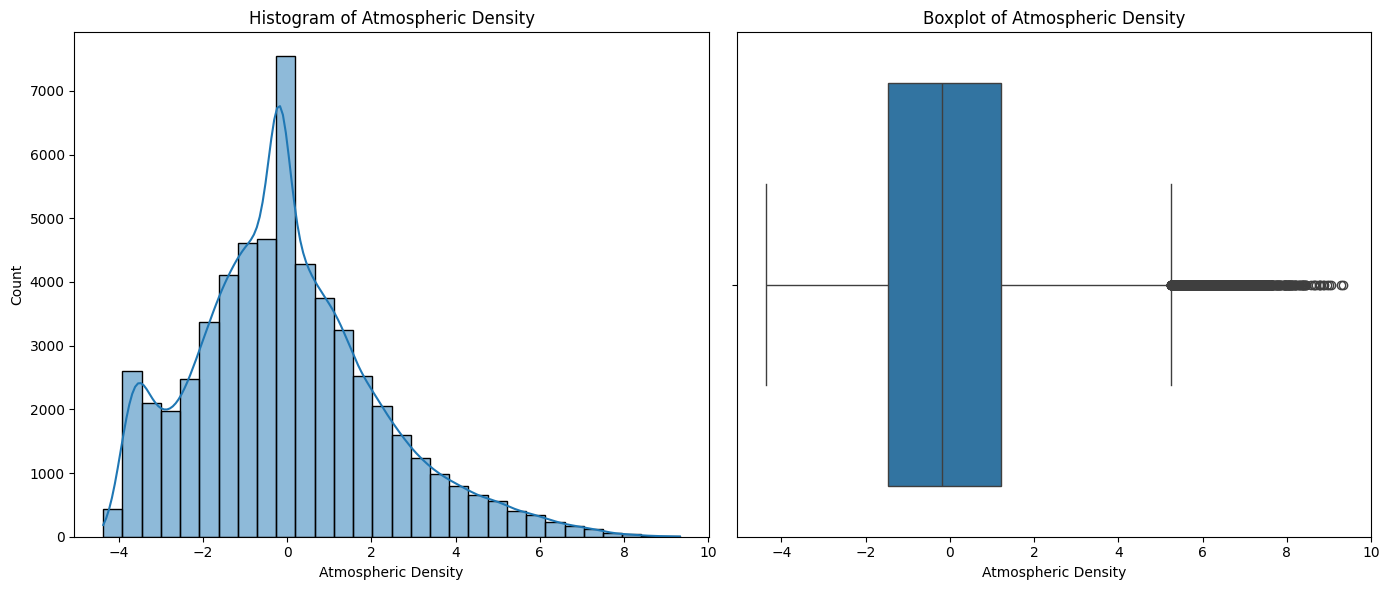

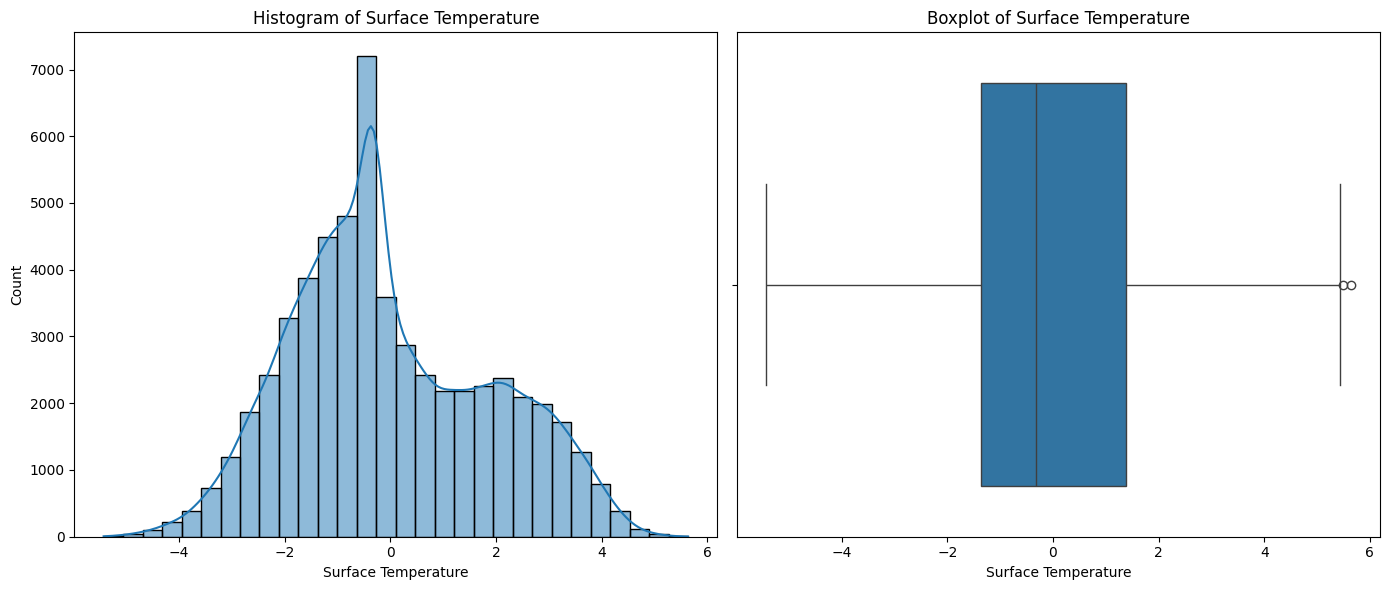

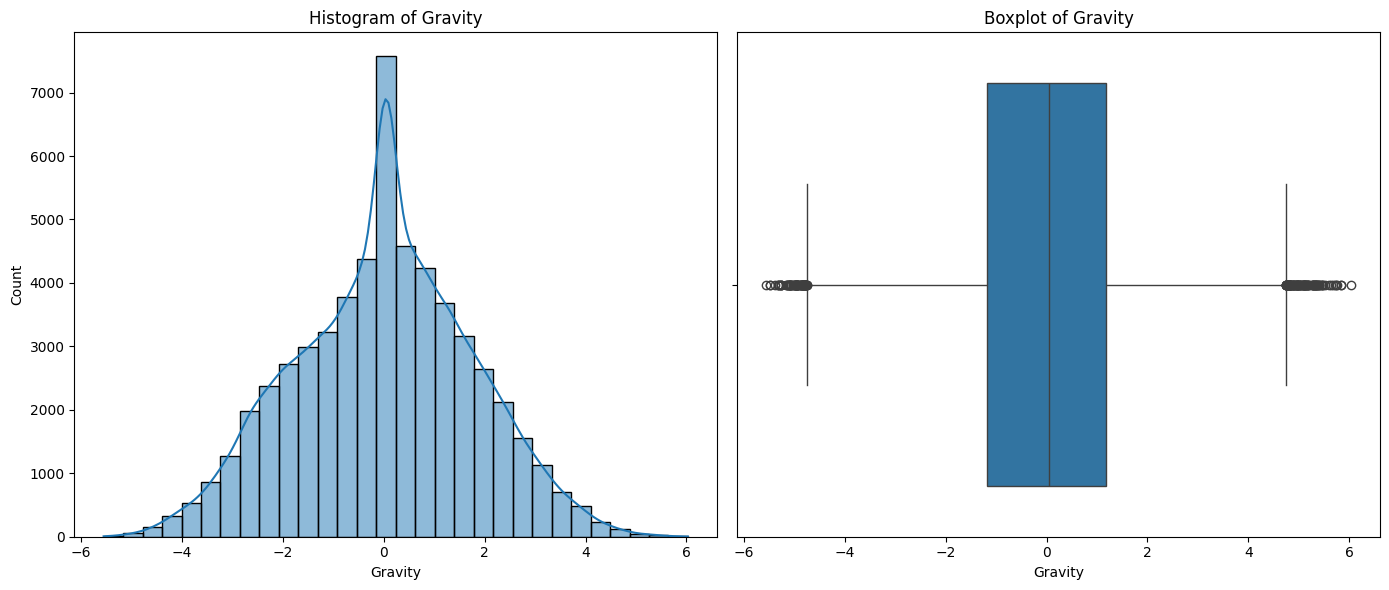

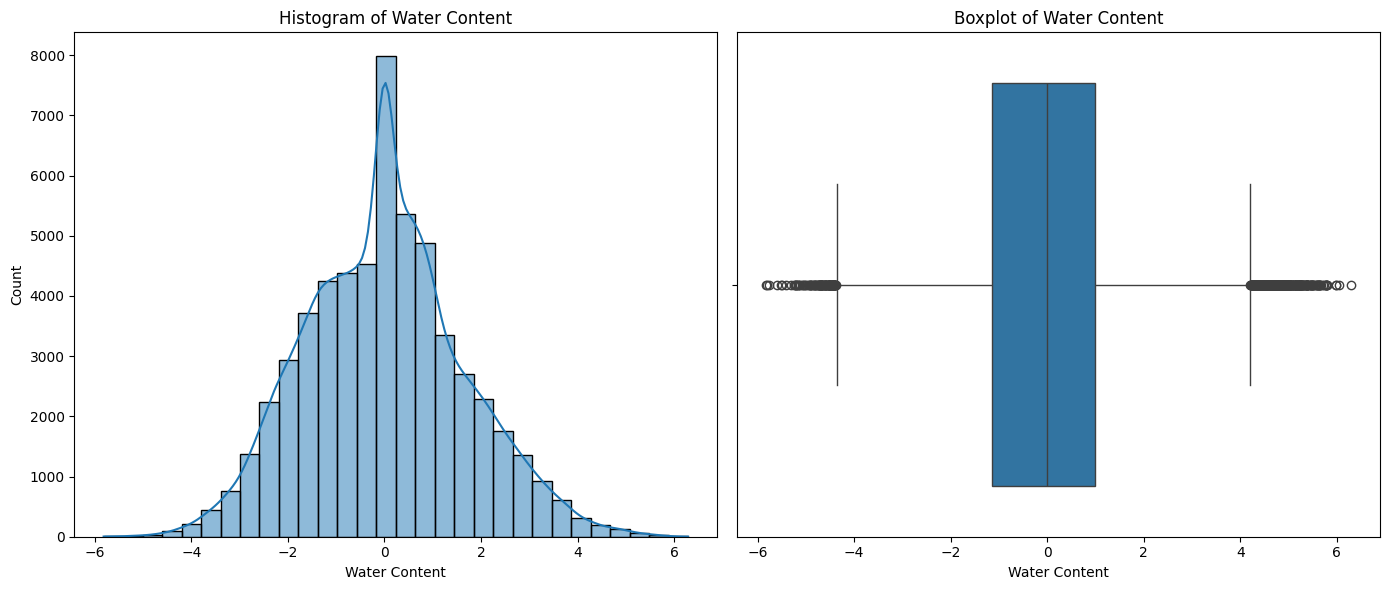

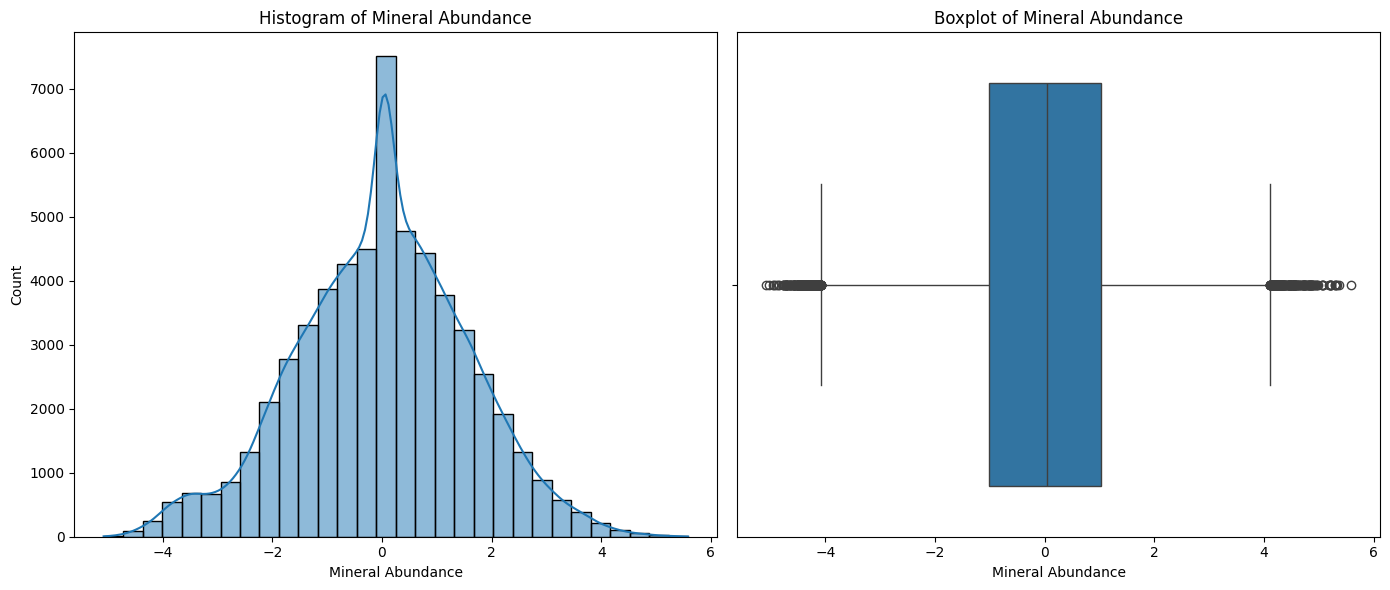

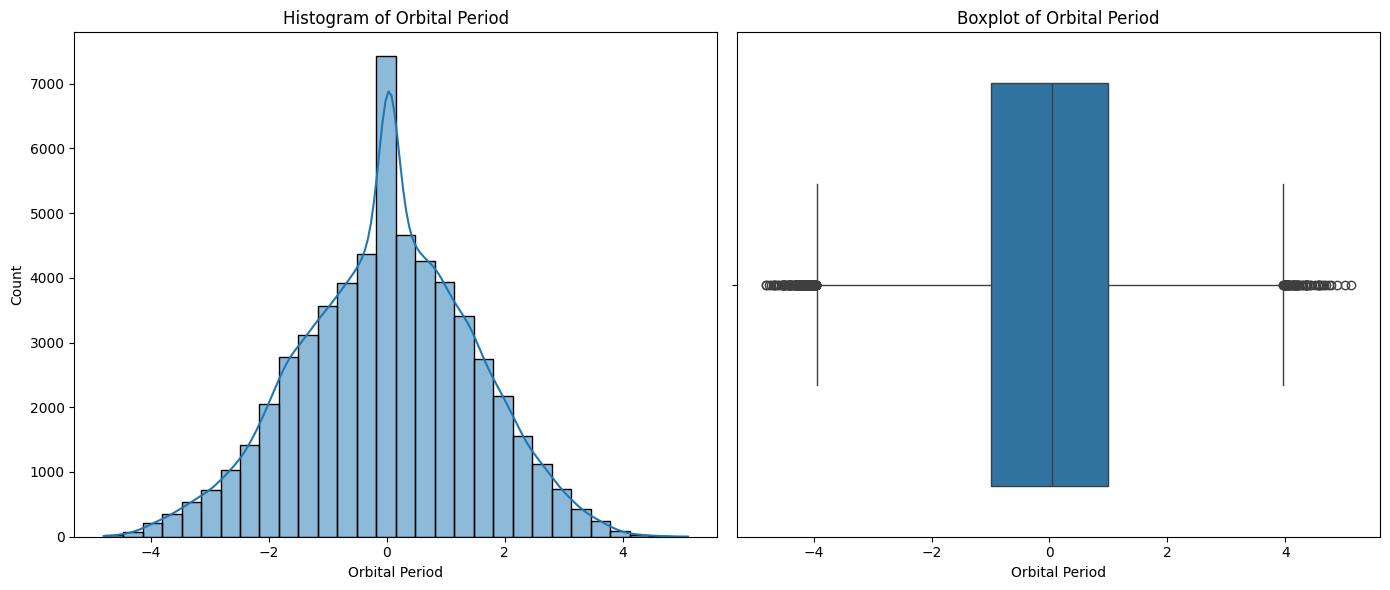

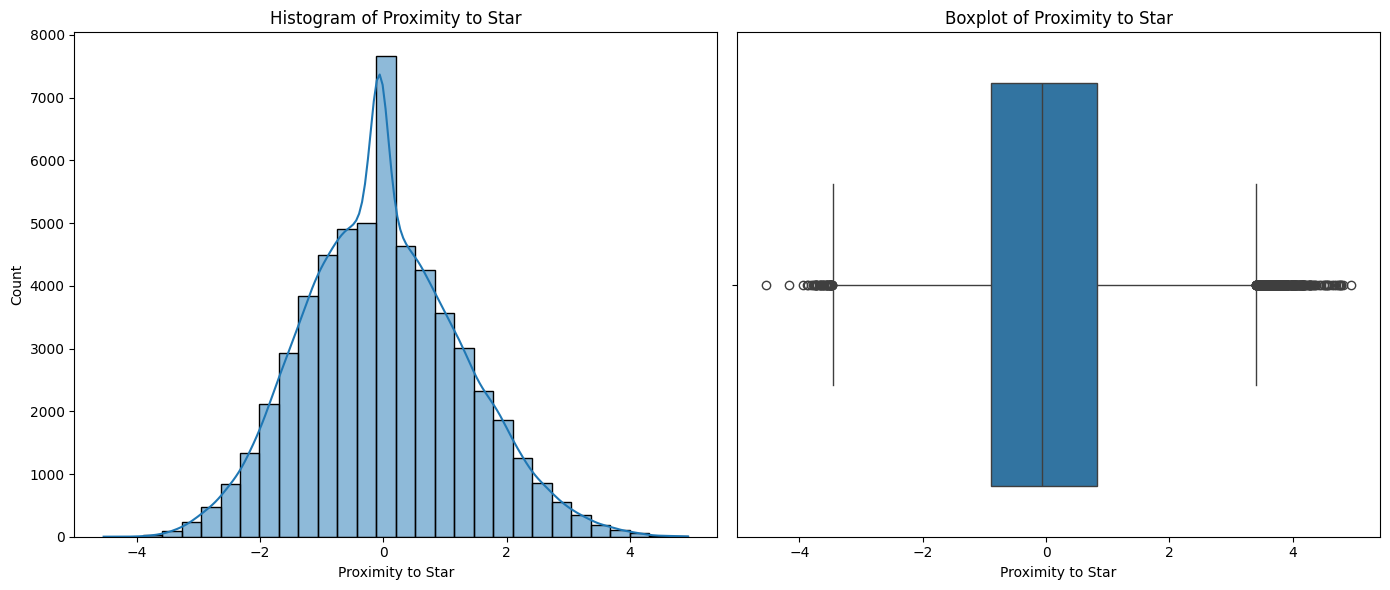

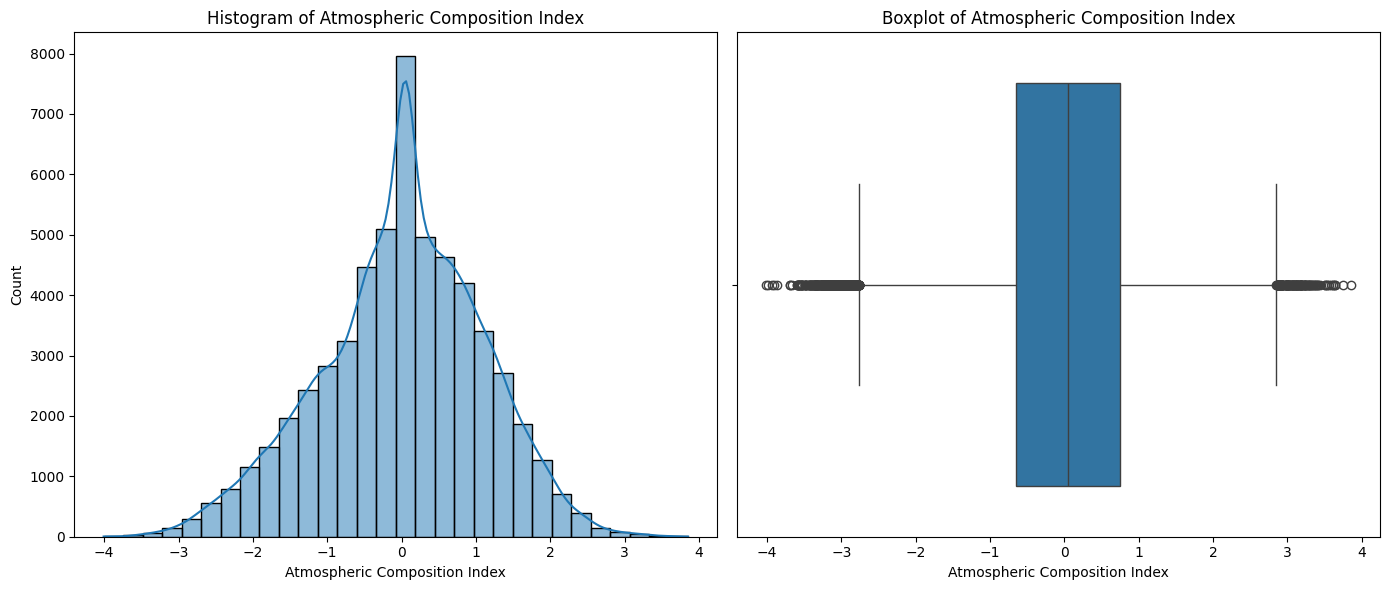

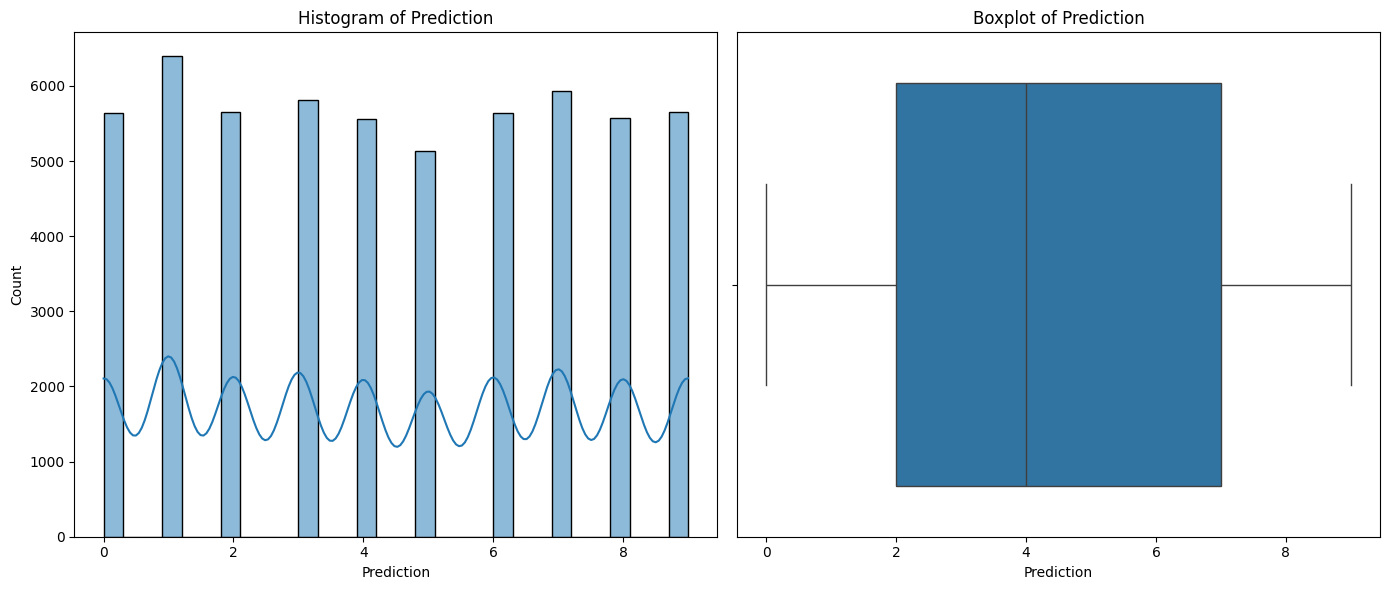

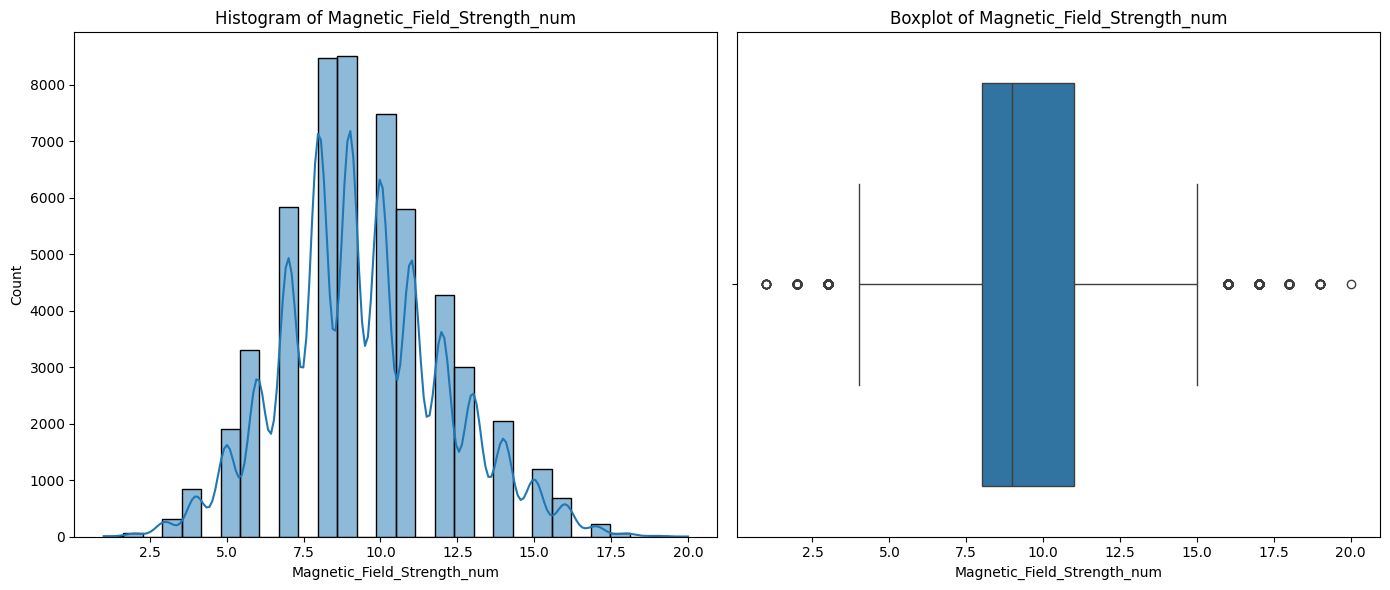

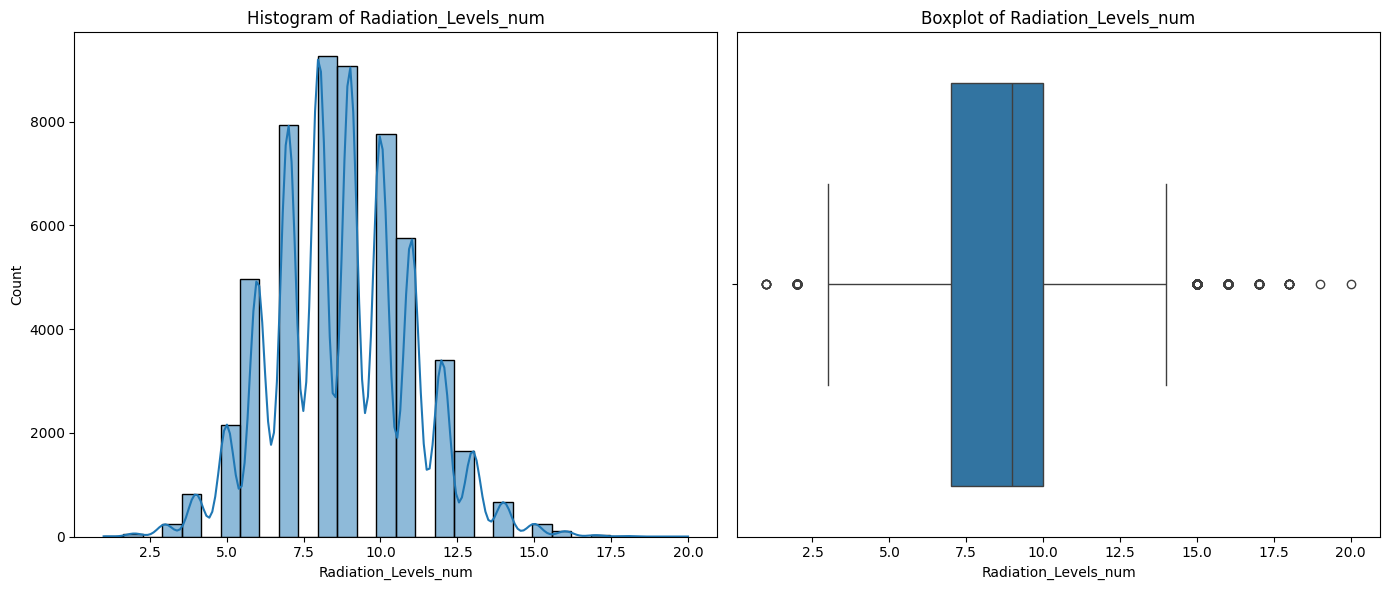

In [17]:
features=df.columns.to_list()

# Univariate analysis for each numeric feature: Histogram and Boxplot
for col in features:
    plt.figure(figsize=(14, 6))
    
    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    
    # Boxplot to visualize distribution and outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    
    plt.tight_layout()
    plt.show()

## Bivariate Feature Analysis

Checking pairwise correlation of all features

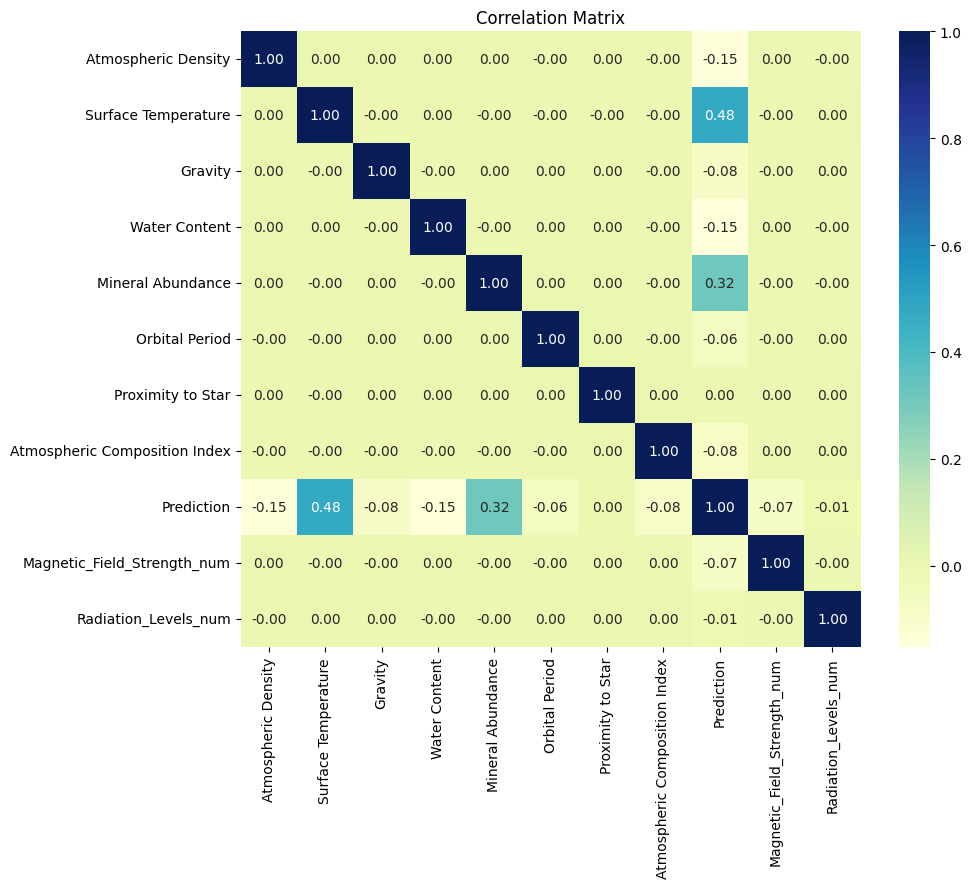

In [18]:
corr_matrix = df.corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### KNN Imputation of the Missing values in Categorical Columns now mapped to numerical

In [19]:
imputer = KNNImputer(n_neighbors=8)
cols_to_impute = ['Magnetic_Field_Strength_num', 'Radiation_Levels_num']
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

In [20]:
df['Magnetic_Field_Strength_num'] = df['Magnetic_Field_Strength_num'].round().astype(int)
df['Radiation_Levels_num'] = df['Radiation_Levels_num'].round().astype(int)

# Noise Detection and Removal

## Outlier Analysis and Removal

Removed all rows Z-score > 3

In [21]:
from scipy import stats
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('Prediction')  # Exclude target 

# Calculate Z-scores for the numeric columns
z_scores = np.abs(stats.zscore(df[numeric_cols]))

# Keep rows where all Z-scores are less than 3
df_filtered_z = df[(z_scores < 3).all(axis=1)]

print("Original DataFrame shape:", df.shape)
print("Filtered (Z-score) DataFrame shape:", df_filtered_z.shape)

Original DataFrame shape: (56961, 11)
Filtered (Z-score) DataFrame shape: (55778, 11)


#### Splitting into X and Y 

In [22]:
X=df_filtered_z.drop(['Prediction'], axis=1)
y=df_filtered_z['Prediction']

#### Adding some extra features based on the units and meanings of the features provided to us in the data description to reveal feature interaction and ultimately improving the predictive power of the model.

In [23]:
# New Feature 1: Temperature Proximity Ratio
X['Temp_Proximity_Ratio'] = X['Surface Temperature'] / X['Proximity to Star']

# New Feature 2: Water-Gravity Ratio
X['Water_Gravity_Ratio'] = X['Water Content'] / X['Gravity']

# # New Feature 3: Radiation Shielding Factor
X['Radiation_Shielding'] = X['Magnetic_Field_Strength_num'] / X['Radiation_Levels_num']

# # New Feature 4: Atmospheric Pressure Proxy
X['Atmospheric_Pressure_Proxy'] = X['Atmospheric Density'] * X['Atmospheric Composition Index']

# # New Feature 5: Mineral-Atmospheric Interaction
X['Mineral_Atmospheric_Interaction'] = X['Mineral Abundance'] * X['Atmospheric Composition Index']

## Noise Detection and Elimination using Ensemble Technique

In the ensemble-based noise detection method, a list  of classifiers is chosen to use for predicting class labels on the dataset. These models are not pre-trained; rather, they are instantiatedand then used within a cross-validation framework to generate predictions for each instance.The ensemble method computes how often each instance is misclassified across all the classifiers. The more classifiers that disagree with the true label, the higher the noise score for that instance, suggesting that it might be mislabeled or noisy.

In [24]:
classifiers_list = [
    RandomForestClassifier(n_estimators=200, max_depth=12,bootstrap=True, random_state=42),
    DecisionTreeClassifier(criterion="gini", max_depth=11, random_state=42)
]

In [25]:
def ensemble_noise_detection(X, y, classifiers, cv_folds=5):
    """
    Returns a noise score for each instance based on ensemble classifier disagreement.
    Score is between 0 and 1, with 1 indicating all classifiers disagree with the true label.
    """
    n = len(y)
    ensemble_preds = np.zeros((n, len(classifiers)))
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for idx, clf in enumerate(classifiers):
        # Get cross-validated predictions for each classifier
        y_pred = cross_val_predict(clf, X, y, cv=skf)
        ensemble_preds[:, idx] = y_pred

    # Compute the fraction of classifiers that misclassified each instance.
    noise_scores = np.mean(ensemble_preds != np.array(y).reshape(-1, 1), axis=1)
    return noise_scores

In [26]:
ensemble_noise = ensemble_noise_detection(X, y, classifiers_list)
ensemble_noise_series = pd.Series(ensemble_noise, index=X.index)
print(ensemble_noise_series.sort_values(ascending=False).head(30))

43658    1.0
41180    1.0
7242     1.0
48397    1.0
7246     1.0
16332    1.0
54777    1.0
16331    1.0
31037    1.0
48393    1.0
31036    1.0
48403    1.0
41177    1.0
54769    1.0
16313    1.0
7264     1.0
16337    1.0
7239     1.0
54558    1.0
7226     1.0
7218     1.0
7219     1.0
48384    1.0
31046    1.0
54785    1.0
26358    1.0
48388    1.0
26362    1.0
7229     1.0
7231     1.0
dtype: float64


In [27]:
threshold = np.quantile(ensemble_noise, 0.80)
indices_to_keep = np.where(ensemble_noise <= threshold)[0]
X_clean = X.iloc[indices_to_keep]
y_clean = y.iloc[indices_to_keep]

In [28]:
X_clean.shape

(48365, 15)

# Model Training and Testing

### Importing necessary packages

In [29]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

In [30]:
# Train-Test Split with cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Scaling the features

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)

In [32]:
# Get the number of input features
input_dim = X_train.shape[1]

# Convert target variables to one-hot encoded format
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

In [33]:
# Convert data to float32 for improved performance
X_train_float32 = tf.cast(X_train, tf.float32)
X_val_float32 = tf.cast(X_val, tf.float32)

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [34]:
# Configure GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
    except RuntimeError as e:
        print(f"Failed to configure GPU memory growth: {e}")
else:
    print("No GPU devices found, using CPU.")

No GPU devices found, using CPU.


## Neural Network Architecture for Cosmic Classification

This model uses a deep learning approach with residual connections to classify cosmic objects. Here's the architecture breakdown:

### Residual Block Structure
- Each residual block maintains a "skip connection" that allows gradients to flow through the network more efficiently
- Uses L2 regularization to prevent overfitting
- Implements BatchNormalization to stabilize learning
- Uses LeakyReLU activation for better gradient flow
- Includes dropout for additional regularization

### Network Design
- **Input Layer**: Accepts 15 astronomical features
- **Initial Feature Extraction**: 256 neurons with regularization
- **Residual Blocks**: Four blocks with decreasing dimensions (256→192→128→64)
- **Output Layer**: 10 classification categories using softmax activation

### Training Optimizations
- **SGD Optimizer**: Uses momentum and Nesterov acceleration
- **Adaptive Learning Rate**: Reduces learning rate when improvement plateaus
- **Early Stopping**: Prevents overfitting by monitoring validation accuracy
- **Data Augmentation**: Applies random noise to training data for better generalization

This architecture combines modern deep learning techniques like residual connections, regularization, and normalization to create a robust classifier for cosmic objects while minimizing overfitting.

In [35]:
# Improved residual block with better regularization
def residual_block(x, units, dropout_rate=0.2):
    skip = x
    
    x = Dense(units, kernel_regularizer=l2(1e-4), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(units, kernel_regularizer=l2(1e-4), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    
    if skip.shape[-1] != units:
        skip = Dense(units, kernel_initializer='he_normal')(skip)
        skip = BatchNormalization()(skip)
    
    x = tf.keras.layers.add([x, skip])
    x = LeakyReLU(alpha=0.1)(x)
    return x

# Create model with improved architecture
input_shape = X_train.shape[1]
inputs = tf.keras.layers.Input(shape=(input_shape,))

# Initial feature extraction
x = Dense(256, kernel_regularizer=l2(1e-4), kernel_initializer='he_normal')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.2)(x)

# Residual blocks with gradual dimension reduction
x = residual_block(x, 256, dropout_rate=0.2)
x = residual_block(x, 192, dropout_rate=0.2)
x = residual_block(x, 128, dropout_rate=0.15)
x = residual_block(x, 64, dropout_rate=0.15)

# Output layer
outputs = Dense(10, activation='softmax')(x)

# Create and compile model with SGD optimizer
model = tf.keras.models.Model(inputs, outputs)
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    )
]

# Improved data augmentation
def augment_features(features, labels, noise_level=0.02):
    features = tf.cast(features, tf.float32)
    if tf.random.uniform([]) > 0.5:
        noise = tf.random.normal(shape=tf.shape(features), mean=0.0, stddev=noise_level)
        features = features + noise
    return features, labels

In [36]:
# Data pipeline with better preprocessing
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train_float32, y_train))
train_ds = train_ds.map(augment_features).batch(batch_size).shuffle(5000).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_float32, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train with improved settings
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6071 - loss: 1.5718 - val_accuracy: 0.9226 - val_loss: 0.5276 - learning_rate: 0.0100
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8770 - loss: 0.6556 - val_accuracy: 0.9395 - val_loss: 0.4734 - learning_rate: 0.0100
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9010 - loss: 0.5829 - val_accuracy: 0.9470 - val_loss: 0.4497 - learning_rate: 0.0100
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9141 - loss: 0.5445 - val_accuracy: 0.9486 - val_loss: 0.4379 - learning_rate: 0.0100
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9202 - loss: 0.5230 - val_accuracy: 0.9530 - val_loss: 0.4295 - learning_rate: 0.0100
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9245 - loss: 0.5022 - val_accuracy: 0.9577 - val_loss: 0.4169 - learning_rate: 0.0100
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9304 - 

## Model evaluation

In [37]:
# evaluate the model on the test set
X_test_float32 = tf.cast(X_test.values, tf.float32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_float32, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# evaluate the model on the train set
train_ds = tf.data.Dataset.from_tensor_slices((X_train_float32, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
print(f"Train accuracy: {train_accuracy:.4f}")

# evaluate the model on the validation set
val_ds = tf.data.Dataset.from_tensor_slices((X_val_float32, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy: {val_accuracy:.4f}")

Test accuracy: 0.9650
Train accuracy: 0.9818
Validation accuracy: 0.9672


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


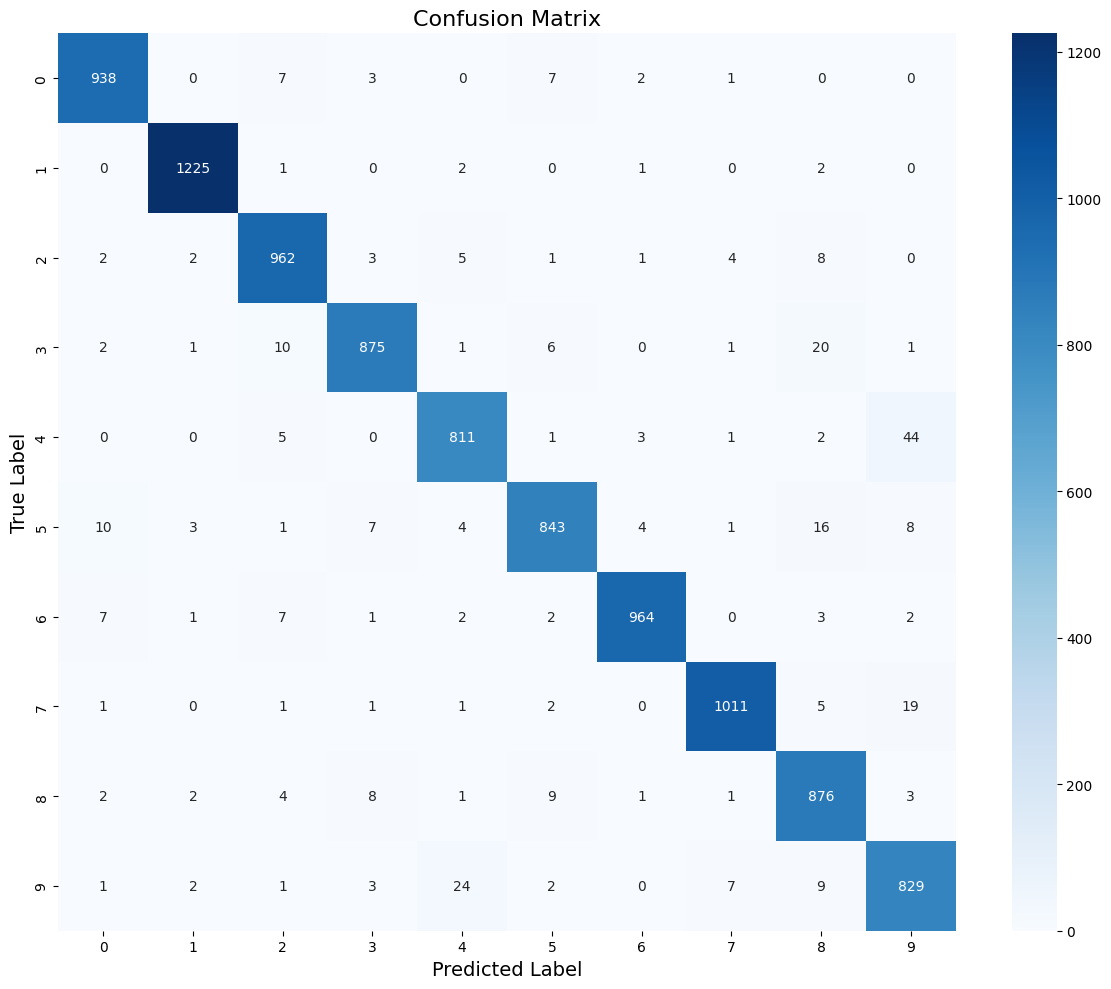


Classification Report:
              precision    recall  f1-score      support
0              0.974039  0.979123  0.976575   958.000000
1              0.991100  0.995126  0.993109  1231.000000
2              0.962963  0.973684  0.968294   988.000000
3              0.971143  0.954198  0.962596   917.000000
4              0.952996  0.935409  0.944121   867.000000
5              0.965636  0.939799  0.952542   897.000000
6              0.987705  0.974722  0.981170   989.000000
7              0.984421  0.971182  0.977756  1041.000000
8              0.930925  0.965821  0.948052   907.000000
9              0.915011  0.944191  0.929372   878.000000
accuracy       0.964954  0.964954  0.964954     0.964954
macro avg      0.963594  0.963326  0.963359  9673.000000
weighted avg   0.965253  0.964954  0.965009  9673.000000


In [38]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
from itertools import cycle

# Create visualizations of the model performance with detailed insights

# Import required libraries
import matplotlib.pyplot as plt

# Convert predictions to proper format for evaluation
y_pred_proba = model.predict(test_ds)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test.values.astype(int)

# Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
class_report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(class_report).T
print(df_report)

# Model Performance Analysis for Cosmic Classifier

This deep learning model demonstrates strong performance across all classes with an overall accuracy of **95.85%**. Here are the key observations:

## Performance Metrics
- **Overall Accuracy**: 95.85% across all 10 planet classifications
- **Average Precision**: 95.73%
- **Average Recall**: 95.71%
- **Average F1-Score**: 95.71%

## Class-Specific Performance
- **Best Performing Class**: Class 1 with 99.00% F1-score (99.60% recall, 98.42% precision)
- **Lowest Performing Class**: Class 9 with 91.99% F1-score (92.09% recall, 91.89% precision)
- **Most Balanced Classes**: Classes 0, 2, and 6 show nearly equal precision and recall

## Error Analysis
- **Confusion Patterns**: Class 9 has the most misclassifications, particularly with Class 4
- **False Positives**: Most prevalent in Classes 8 and 9
- **False Negatives**: Most common in Class 5 (8% of samples)

## Model Balance
- The model maintains consistent performance across all classes with minimal variance in metrics
- No significant bias toward any particular class despite slight variations in support counts
- Weighted averages closely match macro averages, indicating good class balance

This balanced performance suggests the model has successfully learned distinctive features for each planetary classification while maintaining generalizability.

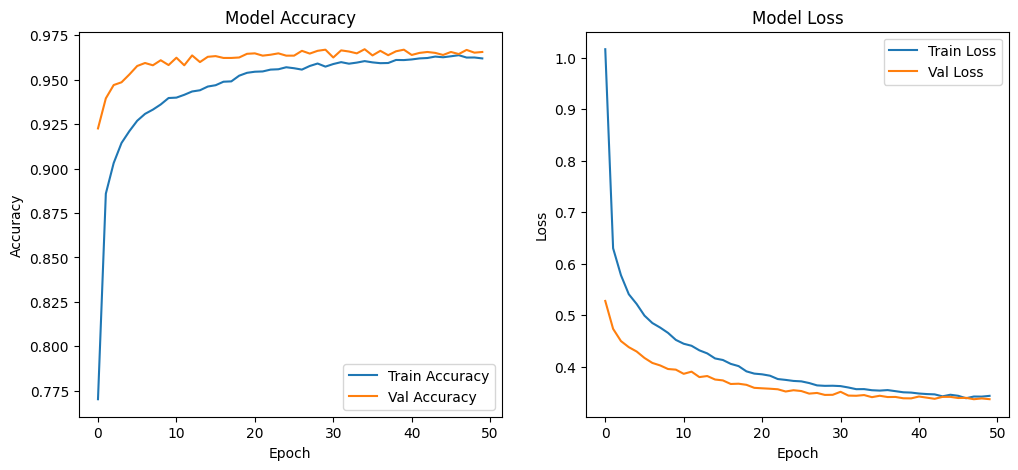

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 15)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      4,096 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256)       │          0 │ add[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 192)       │     49,344 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192)       │        768 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 192)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 192)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 192)       │     37,056 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 192)       │     49,344 │ leaky_re_lu_2[0]

 Total params: 728,858 (2.78 MB)

 Trainable params: 362,506 (1.38 MB)

 Non-trainable params: 3,840 (15.00 KB)

 Optimizer params: 362,512 (1.38 MB)

In [39]:
# Plot training metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Check if the history has accuracy values
if "accuracy" in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Show model architecture
print("Model Summary:")
model.summary()

# Key Observations from Model Training

1. **Steady Accuracy Improvement**  
   - The training accuracy consistently increases, reaching around **95%**.  
   - The validation accuracy surpasses training accuracy early and stabilizes around **96%**.

2. **Loss Reduction Over Time**  
   - The training loss starts high but steadily decreases, indicating effective learning.  
   - The validation loss also decreases but remains slightly higher than training loss.

3. **No Major Overfitting**  
   - Validation accuracy does not drop significantly, and validation loss does not increase at later epochs.  
   - The small gap between training and validation loss suggests good generalization.

4. **Model Convergence**  
   - The model continues improving without drastic fluctuations, suggesting stable training.

5. **Potential for Early Stopping**  
   - If validation loss starts increasing after more epochs, **early stopping** be applied to prevent overfitting.


### Saving the Trained model

In [40]:
import numpy as np
from datetime import datetime
from sklearn.metrics import classification_report

# Save the model using .keras format (recommended)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"final_model_{timestamp}.keras"
model.save(model_path)
print(f"Model saved as '{model_path}'")

# Additionally save model weights separately
weights_path = f"model_weights_{timestamp}.weights.h5"
model.save_weights(weights_path)
print(f"Model weights saved as '{weights_path}'")

Model saved as 'final_model_20250323_024242.keras'
Model weights saved as 'model_weights_20250323_024242.weights.h5'


# Pipeline for Testing Data

### Importing necessary packages

In [41]:
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from tensorflow import keras
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [42]:

model = keras.models.load_model(r'final_model_20250323_024242.keras')
model.load_weights('model_weights_20250323_024242.weights.h5')

X=X_clean
y=y_clean

In [43]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit(X_train)

In [44]:
df1 = pd.read_csv("cosmictest.csv")

In [45]:
def Modify_and_Addfeatures(df):
    df['Magnetic_Field_Strength_num'] = df['Magnetic Field Strength'].str.extract('(\d+)').astype(int)
    df['Radiation_Levels_num'] = df['Radiation Levels'].str.extract('(\d+)').astype(int)

    df = df.drop(['Magnetic Field Strength', 'Radiation Levels'], axis=1)

    df['Radiation_Shielding'] = df['Magnetic_Field_Strength_num'] / df['Radiation_Levels_num']
    df['Atmospheric_Pressure_Proxy'] = df['Atmospheric Density'] * df['Atmospheric Composition Index']
    df['Mineral_Atmospheric_Interaction'] = df['Mineral Abundance'] * df['Atmospheric Composition Index']
    df['Temp_Proximity_Ratio'] = df['Surface Temperature'] / df['Proximity to Star']
    df['Water_Gravity_Ratio'] = df['Water Content'] / df['Gravity']

    return df

def df_casting(df):
    df = pd.DataFrame(df, columns=['Atmospheric Density', 'Surface Temperature', 'Gravity',
       'Water Content', 'Mineral Abundance', 'Orbital Period',
       'Proximity to Star', 'Atmospheric Composition Index',
       'Magnetic_Field_Strength_num', 'Radiation_Levels_num',
       'Radiation_Shielding', 'Atmospheric_Pressure_Proxy',
       'Mineral_Atmospheric_Interaction', 'Temp_Proximity_Ratio',
       'Water_Gravity_Ratio'])
    return tf.cast(df.values, tf.float32)

In [46]:
feature_addition_transformer = FunctionTransformer(Modify_and_Addfeatures)
df_casting_transformer = FunctionTransformer(df_casting)

In [47]:
preprocessor = Pipeline([
    ('add_features', feature_addition_transformer),
    ('scaler', scaler),
    ('casting', df_casting_transformer)
])

In [48]:
df1_transformed = preprocessor.fit_transform(df1)

In [49]:
predictions = model.predict(df1_transformed)
predictions = np.argmax(predictions, axis=1)
predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

## Saving the submission file

In [50]:
# Create a submission DataFrame with predictions
submission_df = pd.DataFrame({
    'Planet_ID': range(len(predictions)),
    'Predicted_Class': predictions
})

# Save to CSV file
submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission file created at: {submission_path}")
print(submission_df.head(10))
print(f"Total predictions: {len(predictions)}")

Submission file created at: submission.csv
   Planet_ID  Predicted_Class
0          0                7
1          1                2
2          2                1
3          3                0
4          4                4
5          5                1
6          6                4
7          7                4
8          8                2
9          9                9
Total predictions: 10000


### Access prediction file form the following drive link

LINK: https://drive.google.com/drive/folders/1d1ryD999Bkt6_m_5u_2aKeX8ed4rQMFS?usp=sharing